## Import libs, set paths and load params

In [1]:
import os
import numpy as np
import pandas as pd
import sys
import csv
sys.path.insert(0, "../src")
ART_NET_PATH = "../networks"

import auxilary_functions as f
from generation_algorithm import *
from copy import deepcopy
import networkx as nx
from time import sleep
import statistics
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [12]:
import tracemalloc

tracemalloc.start()

snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics("lineno")

[print(stat) for stat in top_stats]

/home/erik/anaconda3/envs/python_env/lib/python3.7/json/decoder.py:353: size=5540 B, count=84, average=66 B
/home/erik/anaconda3/envs/python_env/lib/python3.7/site-packages/tornado/gen.py:216: size=3928 B, count=11, average=357 B
/home/erik/anaconda3/envs/python_env/lib/python3.7/site-packages/IPython/core/compilerop.py:101: size=3807 B, count=72, average=53 B
/home/erik/anaconda3/envs/python_env/lib/python3.7/enum.py:315: size=3720 B, count=13, average=286 B
/home/erik/anaconda3/envs/python_env/lib/python3.7/signal.py:30: size=3624 B, count=13, average=279 B
/home/erik/anaconda3/envs/python_env/lib/python3.7/enum.py:553: size=3192 B, count=13, average=246 B
/home/erik/anaconda3/envs/python_env/lib/python3.7/site-packages/ipykernel/kernelbase.py:266: size=2592 B, count=6, average=432 B
/home/erik/anaconda3/envs/python_env/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py:492: size=2176 B, count=4, average=544 B
/home/erik/anaconda3/envs/python_env/lib/python3.7/site-packages/torna

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Load Yeast Tnet and select the FFL-based component

In [2]:
interaction_matrix = f.get_interaction_matrix(cfg)

%time
motifs, counter = f.motif_search(cfg, interaction_matrix, batch_size=10000)
motifs_orig = motifs["030T"]
counter

ffl_nodes = list(set(sum([list(map(int, x.split("_"))) for x in motifs_orig], [])))
interaction_matrix_ffl = np.zeros((len(ffl_nodes), len(ffl_nodes)))
for motif in motifs_orig:
    motif = f.split_motif(motif)
    motif_new = list(ffl_nodes.index(x) for x in motif)
    interaction_matrix_ffl[np.ix_(motif_new, motif_new)] = \
    interaction_matrix[np.ix_(motif, motif)]
interaction_matrix_ffl.shape, interaction_matrix_ffl.sum()

# Vertex-based motif network on FFL
motifs_network = f.build_vmn(motifs_orig, verbose=True)
V = nx.Graph(motifs_network)
nx.is_connected(V)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


100%|██████████| 5676765/5676765 [00:19<00:00, 284780.49it/s]


True

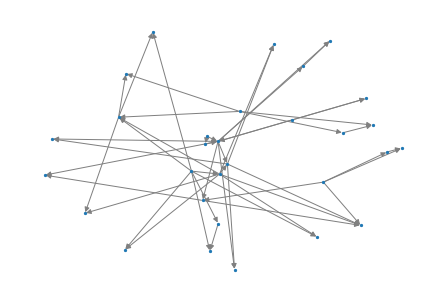

In [3]:
substrate_matrix = get_network_nucleus(
        interaction_matrix, motifs=motifs_orig, motifs_network=motifs_network, min_size=30
    )

substrate_matrix_t = substrate_matrix.transpose()
substrate_matrix_graph = nx.DiGraph(substrate_matrix_t)
nx.draw(substrate_matrix_graph, node_size = 5, edge_color = 'gray')

In [4]:
substrate_matrix_graph.out_degree()

OutDegreeView({0: 0, 1: 2, 2: 4, 3: 1, 4: 0, 5: 7, 6: 4, 7: 0, 8: 3, 9: 4, 10: 0, 11: 0, 12: 8, 13: 7, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1, 20: 0, 21: 1, 22: 0, 23: 2, 24: 0, 25: 1, 26: 0, 27: 2, 28: 1, 29: 0})

In [5]:
substrate_matrix_graph.in_degree()

InDegreeView({0: 4, 1: 2, 2: 0, 3: 1, 4: 2, 5: 1, 6: 2, 7: 2, 8: 3, 9: 0, 10: 2, 11: 2, 12: 3, 13: 0, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 1, 20: 2, 21: 1, 22: 2, 23: 0, 24: 2, 25: 1, 26: 2, 27: 0, 28: 1, 29: 2})

## Topology stats

In [8]:
def collect_topology_stats(growth_pace_vec, matrix_size_vec, initial_size_vec, barabasi_num_vec):
    network_topology_stats = {}
    #import resource
    
    for growth_pace_num in growth_pace_vec:
        for final_size in matrix_size_vec:
            for initial_size in initial_size_vec:
                for barabasi_num in barabasi_num_vec:
                
                    #generate network
                    artificial_matrix_ffl = generate_artificial_network(
                        interaction_matrix, motifs=motifs_orig, motifs_network=motifs_network,
                        nucleus_size=initial_size, network_size=final_size, growth_pace=growth_pace_num,
                        reference_matrix=interaction_matrix_ffl, growth_barabasi = barabasi_num, sparsity=3)
                    
                    ffl_perc = artificial_matrix_ffl[3]
                    sparsity = artificial_matrix_ffl[2]
                    time_spent = artificial_matrix_ffl[1]
                    artificial_matrix_ffl = artificial_matrix_ffl[0]

                    #GS-to-Networkx format conversion
                    art_matrix = artificial_matrix_ffl.transpose()

                    if not os.path.exists(ART_NET_PATH):
                            os.mkdir(ART_NET_PATH)
                    joblib.dump(
                            art_matrix, os.path.join(ART_NET_PATH,'_'+f"test{art_matrix.shape[0]}.gz")

                    )

                    #create edgelist
                    D1 = nx.DiGraph(art_matrix)
                    nx.write_edgelist(D1, os.path.join(ART_NET_PATH, "test.tsv"), data=False)

                    #analyze network
                    #network_test = f.read_df_as_network(os.path.join(ART_NET_PATH, "test.tsv"))
                    #diameter = nx.diameter(network_test)
                    #shortest_path = nx.average_shortest_path_length(network_test)

                    #collect stats
                    #key_to_dic = '_'.join(str(x) for x in [final_size,initial_size,growth_pace_num,barabasi_num])
                    #list_with_stats = [final_size, initial_size, sparsity,
                    #                   np.round(shortest_path, 4), diameter, growth_pace_num, barabasi_num, ffl_perc, time_spent]
                    #network_topology_stats[key_to_dic] = list_with_stats

    return network_topology_stats, artificial_matrix_ffl

In [9]:
dict_with_stats, matrix = collect_topology_stats([0.4],[500],[30],[0.3])

Nucleus matrix shape: (30, 30)


num of iterations: 1
ffl-components size: 30
num of nodes: 0
memory usage (MB): 889.389056
free memory left (MB): 9882.238976
The CPU usage is:: 47.0
num of iterations: 2
ffl-components size: 30
num of nodes: 0
memory usage (MB): 889.389056
free memory left (MB): 9882.238976
The CPU usage is:: 60.6
num of iterations: 3
ffl-components size: 30
num of nodes: 2
memory usage (MB): 889.389056
free memory left (MB): 9882.238976
The CPU usage is:: 62.5
num of iterations: 4
ffl-components size: 31
num of nodes: 2
memory usage (MB): 889.389056
free memory left (MB): 9881.72288
The CPU usage is:: 40.0
num of iterations: 5
ffl-components size: 32
num of nodes: 2
memory usage (MB): 889.389056
free memory left (MB): 9881.72288
The CPU usage is:: 37.5
num of iterations: 6
ffl-components size: 32
num of nodes: 2
memory usage (MB): 889.389056
free memory left (MB): 9881.72288
The CPU usage is:: 45.5
num of iterations: 7
ffl-components size: 32
num of nodes: 2
memory us

num of iterations: 66
ffl-components size: 43
num of nodes: 10
memory usage (MB): 889.389056
free memory left (MB): 9884.717056
The CPU usage is:: 21.4
num of iterations: 67
ffl-components size: 44
num of nodes: 10
memory usage (MB): 889.389056
free memory left (MB): 9884.717056
The CPU usage is:: 41.2
num of iterations: 68
ffl-components size: 44
num of nodes: 10
memory usage (MB): 889.389056
free memory left (MB): 9884.975104
The CPU usage is:: 21.4
num of iterations: 69
ffl-components size: 44
num of nodes: 10
memory usage (MB): 889.389056
free memory left (MB): 9885.147136
The CPU usage is:: 41.2
num of iterations: 70
ffl-components size: 44
num of nodes: 10
memory usage (MB): 889.389056
free memory left (MB): 9884.975104
The CPU usage is:: 26.7
num of iterations: 71
ffl-components size: 44
num of nodes: 10
memory usage (MB): 889.389056
free memory left (MB): 9884.975104
The CPU usage is:: 23.1
num of iterations: 72
ffl-components size: 44
num of nodes: 10
memory usage (MB): 889.38

num of iterations: 125
ffl-components size: 52
num of nodes: 29
memory usage (MB): 889.389056
free memory left (MB): 9881.3952
The CPU usage is:: 33.3
num of iterations: 126
ffl-components size: 52
num of nodes: 29
memory usage (MB): 889.389056
free memory left (MB): 9881.3952
The CPU usage is:: 23.8
num of iterations: 127
ffl-components size: 52
num of nodes: 29
memory usage (MB): 889.389056
free memory left (MB): 9880.088576
The CPU usage is:: 27.3
num of iterations: 128
ffl-components size: 52
num of nodes: 29
memory usage (MB): 889.389056
free memory left (MB): 9880.51456
The CPU usage is:: 36.0
num of iterations: 129
ffl-components size: 53
num of nodes: 29
memory usage (MB): 889.389056
free memory left (MB): 9880.51456
The CPU usage is:: 22.7
num of iterations: 130
ffl-components size: 53
num of nodes: 29
memory usage (MB): 889.389056
free memory left (MB): 9880.489984
The CPU usage is:: 22.7
num of iterations: 131
ffl-components size: 53
num of nodes: 29
memory usage (MB): 889.3

num of iterations: 179
ffl-components size: 63
num of nodes: 44
memory usage (MB): 889.389056
free memory left (MB): 9877.905408
The CPU usage is:: 46.3
num of iterations: 180
ffl-components size: 63
num of nodes: 44
memory usage (MB): 889.389056
free memory left (MB): 9877.880832
The CPU usage is:: 29.0
num of iterations: 181
ffl-components size: 63
num of nodes: 44
memory usage (MB): 889.389056
free memory left (MB): 9877.880832
The CPU usage is:: 22.6
num of iterations: 182
ffl-components size: 63
num of nodes: 44
memory usage (MB): 889.389056
free memory left (MB): 9878.052864
The CPU usage is:: 23.3
num of iterations: 183
ffl-components size: 63
num of nodes: 44
memory usage (MB): 889.389056
free memory left (MB): 9878.052864
The CPU usage is:: 30.6
num of iterations: 184
ffl-components size: 63
num of nodes: 44
memory usage (MB): 889.389056
free memory left (MB): 9878.052864
The CPU usage is:: 21.9
num of iterations: 185
ffl-components size: 63
num of nodes: 44
memory usage (MB):

num of iterations: 233
ffl-components size: 66
num of nodes: 55
memory usage (MB): 889.389056
free memory left (MB): 9877.467136
The CPU usage is:: 26.2
num of iterations: 234
ffl-components size: 67
num of nodes: 55
memory usage (MB): 889.389056
free memory left (MB): 9877.295104
The CPU usage is:: 23.7
num of iterations: 235
ffl-components size: 67
num of nodes: 55
memory usage (MB): 889.389056
free memory left (MB): 9877.295104
The CPU usage is:: 19.5
num of iterations: 236
ffl-components size: 67
num of nodes: 55
memory usage (MB): 889.389056
free memory left (MB): 9877.295104
The CPU usage is:: 31.8
num of iterations: 237
ffl-components size: 67
num of nodes: 55
memory usage (MB): 889.389056
free memory left (MB): 9877.295104
The CPU usage is:: 25.6
num of iterations: 238
ffl-components size: 67
num of nodes: 55
memory usage (MB): 889.389056
free memory left (MB): 9876.094976
The CPU usage is:: 40.8
num of iterations: 239
ffl-components size: 68
num of nodes: 55
memory usage (MB):

num of iterations: 288
ffl-components size: 80
num of nodes: 67
memory usage (MB): 889.389056
free memory left (MB): 9641.639936
The CPU usage is:: 52.5
num of iterations: 289
ffl-components size: 80
num of nodes: 67
memory usage (MB): 889.389056
free memory left (MB): 9635.770368
The CPU usage is:: 39.1
num of iterations: 290
ffl-components size: 80
num of nodes: 69
memory usage (MB): 889.389056
free memory left (MB): 9608.41728
The CPU usage is:: 33.3
num of iterations: 291
ffl-components size: 80
num of nodes: 69
memory usage (MB): 889.389056
free memory left (MB): 9596.399616
The CPU usage is:: 38.2
num of iterations: 292
ffl-components size: 80
num of nodes: 69
memory usage (MB): 889.389056
free memory left (MB): 9583.435776
The CPU usage is:: 40.7
num of iterations: 293
ffl-components size: 80
num of nodes: 69
memory usage (MB): 889.389056
free memory left (MB): 9575.436288
The CPU usage is:: 40.0
num of iterations: 294
ffl-components size: 81
num of nodes: 69
memory usage (MB): 

num of iterations: 343
ffl-components size: 91
num of nodes: 84
memory usage (MB): 910.770176
free memory left (MB): 9588.363264
The CPU usage is:: 26.9
num of iterations: 344
ffl-components size: 91
num of nodes: 84
memory usage (MB): 919.01952
free memory left (MB): 9587.597312
The CPU usage is:: 27.4
num of iterations: 345
ffl-components size: 91
num of nodes: 84
memory usage (MB): 919.01952
free memory left (MB): 9586.307072
The CPU usage is:: 28.8
num of iterations: 346
ffl-components size: 91
num of nodes: 84
memory usage (MB): 919.01952
free memory left (MB): 9586.307072
The CPU usage is:: 28.0
num of iterations: 347
ffl-components size: 91
num of nodes: 84
memory usage (MB): 920.63744
free memory left (MB): 9587.42528
The CPU usage is:: 26.9
num of iterations: 348
ffl-components size: 91
num of nodes: 84
memory usage (MB): 921.76384
free memory left (MB): 9585.82784
The CPU usage is:: 33.7
num of iterations: 349
ffl-components size: 91
num of nodes: 84
memory usage (MB): 921.76

num of iterations: 398
ffl-components size: 95
num of nodes: 107
memory usage (MB): 939.78624
free memory left (MB): 9643.311104
The CPU usage is:: 27.6
num of iterations: 399
ffl-components size: 95
num of nodes: 107
memory usage (MB): 939.78624
free memory left (MB): 9642.999808
The CPU usage is:: 33.0
num of iterations: 400
ffl-components size: 95
num of nodes: 107
memory usage (MB): 939.78624
free memory left (MB): 9642.57792
The CPU usage is:: 27.1
num of iterations: 401
ffl-components size: 95
num of nodes: 107
memory usage (MB): 939.78624
free memory left (MB): 9642.549248
The CPU usage is:: 29.6
num of iterations: 402
ffl-components size: 95
num of nodes: 107
memory usage (MB): 946.249728
free memory left (MB): 9642.2912
The CPU usage is:: 33.7
num of iterations: 403
ffl-components size: 95
num of nodes: 107
memory usage (MB): 946.249728
free memory left (MB): 9641.017344
The CPU usage is:: 36.7
num of iterations: 404
ffl-components size: 95
num of nodes: 107
memory usage (MB):

num of iterations: 453
ffl-components size: 101
num of nodes: 122
memory usage (MB): 972.279808
free memory left (MB): 9647.06304
The CPU usage is:: 30.4
num of iterations: 454
ffl-components size: 101
num of nodes: 122
memory usage (MB): 972.279808
free memory left (MB): 9646.419968
The CPU usage is:: 32.2
num of iterations: 455
ffl-components size: 102
num of nodes: 122
memory usage (MB): 972.279808
free memory left (MB): 9646.419968
The CPU usage is:: 26.1
num of iterations: 456
ffl-components size: 102
num of nodes: 124
memory usage (MB): 972.279808
free memory left (MB): 9646.419968
The CPU usage is:: 25.0
num of iterations: 457
ffl-components size: 102
num of nodes: 124
memory usage (MB): 972.279808
free memory left (MB): 9647.566848
The CPU usage is:: 27.9
num of iterations: 458
ffl-components size: 103
num of nodes: 124
memory usage (MB): 972.279808
free memory left (MB): 9647.566848
The CPU usage is:: 23.3
num of iterations: 459
ffl-components size: 103
num of nodes: 124
memor

num of iterations: 507
ffl-components size: 111
num of nodes: 132
memory usage (MB): 1011.339264
free memory left (MB): 9595.547648
The CPU usage is:: 27.2
num of iterations: 508
ffl-components size: 111
num of nodes: 132
memory usage (MB): 1011.339264
free memory left (MB): 9595.805696
The CPU usage is:: 24.0
num of iterations: 509
ffl-components size: 112
num of nodes: 132
memory usage (MB): 1011.339264
free memory left (MB): 9595.834368
The CPU usage is:: 28.6
num of iterations: 510
ffl-components size: 112
num of nodes: 132
memory usage (MB): 1016.95488
free memory left (MB): 9593.495552
The CPU usage is:: 41.6
num of iterations: 511
ffl-components size: 112
num of nodes: 132
memory usage (MB): 1016.95488
free memory left (MB): 9594.150912
The CPU usage is:: 30.1
num of iterations: 512
ffl-components size: 113
num of nodes: 132
memory usage (MB): 1016.95488
free memory left (MB): 9594.503168
The CPU usage is:: 29.2
num of iterations: 513
ffl-components size: 113
num of nodes: 132
m

num of iterations: 561
ffl-components size: 123
num of nodes: 140
memory usage (MB): 1057.19808
free memory left (MB): 9649.307648
The CPU usage is:: 23.3
num of iterations: 562
ffl-components size: 123
num of nodes: 140
memory usage (MB): 1057.19808
free memory left (MB): 9649.016832
The CPU usage is:: 25.2
num of iterations: 563
ffl-components size: 123
num of nodes: 140
memory usage (MB): 1057.19808
free memory left (MB): 9650.23744
The CPU usage is:: 31.1
num of iterations: 564
ffl-components size: 123
num of nodes: 140
memory usage (MB): 1057.19808
free memory left (MB): 9648.72192
The CPU usage is:: 44.6
num of iterations: 565
ffl-components size: 123
num of nodes: 142
memory usage (MB): 1057.19808
free memory left (MB): 9648.644096
The CPU usage is:: 32.1
num of iterations: 566
ffl-components size: 123
num of nodes: 142
memory usage (MB): 1057.19808
free memory left (MB): 9648.27136
The CPU usage is:: 28.5
num of iterations: 567
ffl-components size: 123
num of nodes: 142
memory 

num of iterations: 614
ffl-components size: 134
num of nodes: 156
memory usage (MB): 1113.116672
free memory left (MB): 9648.06656
The CPU usage is:: 25.6
num of iterations: 615
ffl-components size: 134
num of nodes: 159
memory usage (MB): 1113.116672
free memory left (MB): 9648.06656
The CPU usage is:: 25.0
num of iterations: 616
ffl-components size: 134
num of nodes: 161
memory usage (MB): 1113.116672
free memory left (MB): 9648.324608
The CPU usage is:: 25.0
num of iterations: 617
ffl-components size: 134
num of nodes: 161
memory usage (MB): 1113.116672
free memory left (MB): 9648.402432
The CPU usage is:: 25.8
num of iterations: 618
ffl-components size: 134
num of nodes: 161
memory usage (MB): 1113.116672
free memory left (MB): 9648.754688
The CPU usage is:: 25.0
num of iterations: 619
ffl-components size: 134
num of nodes: 161
memory usage (MB): 1113.116672
free memory left (MB): 9648.377856
The CPU usage is:: 25.7
num of iterations: 620
ffl-components size: 134
num of nodes: 161


num of iterations: 667
ffl-components size: 139
num of nodes: 169
memory usage (MB): 1155.354624
free memory left (MB): 9841.713152
The CPU usage is:: 40.6
num of iterations: 668
ffl-components size: 139
num of nodes: 169
memory usage (MB): 1155.354624
free memory left (MB): 9842.188288
The CPU usage is:: 34.8
num of iterations: 669
ffl-components size: 139
num of nodes: 169
memory usage (MB): 1155.354624
free memory left (MB): 9843.073024
The CPU usage is:: 26.0
num of iterations: 670
ffl-components size: 139
num of nodes: 169
memory usage (MB): 1155.354624
free memory left (MB): 9841.680384
The CPU usage is:: 27.6
num of iterations: 671
ffl-components size: 139
num of nodes: 169
memory usage (MB): 1172.353024
free memory left (MB): 9841.135616
The CPU usage is:: 30.2
num of iterations: 672
ffl-components size: 139
num of nodes: 169
memory usage (MB): 1175.257088
free memory left (MB): 9842.176
The CPU usage is:: 26.8
num of iterations: 673
ffl-components size: 139
num of nodes: 169
m

num of iterations: 721
ffl-components size: 145
num of nodes: 179
memory usage (MB): 1207.93088
free memory left (MB): 9891.794944
The CPU usage is:: 29.5
num of iterations: 722
ffl-components size: 145
num of nodes: 179
memory usage (MB): 1207.93088
free memory left (MB): 9891.897344
The CPU usage is:: 27.3
num of iterations: 723
ffl-components size: 146
num of nodes: 179
memory usage (MB): 1207.93088
free memory left (MB): 9892.663296
The CPU usage is:: 29.8
num of iterations: 724
ffl-components size: 146
num of nodes: 179
memory usage (MB): 1229.9264
free memory left (MB): 9892.974592
The CPU usage is:: 26.7
num of iterations: 725
ffl-components size: 146
num of nodes: 179
memory usage (MB): 1229.9264
free memory left (MB): 9893.781504
The CPU usage is:: 25.7
num of iterations: 726
ffl-components size: 146
num of nodes: 179
memory usage (MB): 1229.9264
free memory left (MB): 9894.187008
The CPU usage is:: 30.6
num of iterations: 727
ffl-components size: 146
num of nodes: 179
memory 

num of iterations: 775
ffl-components size: 155
num of nodes: 191
memory usage (MB): 1319.03488
free memory left (MB): 9892.655104
The CPU usage is:: 29.0
num of iterations: 776
ffl-components size: 155
num of nodes: 191
memory usage (MB): 1319.03488
free memory left (MB): 9891.807232
The CPU usage is:: 29.2
num of iterations: 777
ffl-components size: 155
num of nodes: 191
memory usage (MB): 1322.655744
free memory left (MB): 9891.561472
The CPU usage is:: 27.0
num of iterations: 778
ffl-components size: 155
num of nodes: 191
memory usage (MB): 1322.655744
free memory left (MB): 9893.142528
The CPU usage is:: 26.9
num of iterations: 779
ffl-components size: 156
num of nodes: 191
memory usage (MB): 1322.655744
free memory left (MB): 9894.457344
The CPU usage is:: 28.4
num of iterations: 780
ffl-components size: 156
num of nodes: 193
memory usage (MB): 1322.655744
free memory left (MB): 9893.924864
The CPU usage is:: 23.8
num of iterations: 781
ffl-components size: 156
num of nodes: 193


num of iterations: 828
ffl-components size: 161
num of nodes: 209
memory usage (MB): 1412.23936
free memory left (MB): 9787.37152
The CPU usage is:: 29.2
num of iterations: 829
ffl-components size: 161
num of nodes: 209
memory usage (MB): 1412.23936
free memory left (MB): 9794.093056
The CPU usage is:: 30.4
num of iterations: 830
ffl-components size: 161
num of nodes: 211
memory usage (MB): 1412.23936
free memory left (MB): 9794.035712
The CPU usage is:: 22.3
num of iterations: 831
ffl-components size: 161
num of nodes: 211
memory usage (MB): 1412.23936
free memory left (MB): 9791.578112
The CPU usage is:: 29.1
num of iterations: 832
ffl-components size: 161
num of nodes: 211
memory usage (MB): 1412.23936
free memory left (MB): 9792.405504
The CPU usage is:: 25.9
num of iterations: 833
ffl-components size: 161
num of nodes: 211
memory usage (MB): 1412.23936
free memory left (MB): 9793.695744
The CPU usage is:: 26.1
num of iterations: 834
ffl-components size: 161
num of nodes: 211
memor

num of iterations: 881
ffl-components size: 167
num of nodes: 217
memory usage (MB): 1472.077824
free memory left (MB): 9788.792832
The CPU usage is:: 36.3
num of iterations: 882
ffl-components size: 167
num of nodes: 217
memory usage (MB): 1472.077824
free memory left (MB): 9787.088896
The CPU usage is:: 43.1
num of iterations: 883
ffl-components size: 167
num of nodes: 217
memory usage (MB): 1472.077824
free memory left (MB): 9784.356864
The CPU usage is:: 34.2
num of iterations: 884
ffl-components size: 167
num of nodes: 217
memory usage (MB): 1472.077824
free memory left (MB): 9782.890496
The CPU usage is:: 34.1
num of iterations: 885
ffl-components size: 167
num of nodes: 217
memory usage (MB): 1472.077824
free memory left (MB): 9794.183168
The CPU usage is:: 30.5
num of iterations: 886
ffl-components size: 168
num of nodes: 217
memory usage (MB): 1472.077824
free memory left (MB): 9849.07776
The CPU usage is:: 31.3
num of iterations: 887
ffl-components size: 169
num of nodes: 217

num of iterations: 934
ffl-components size: 174
num of nodes: 235
memory usage (MB): 1628.864512
free memory left (MB): 9782.439936
The CPU usage is:: 31.1
num of iterations: 935
ffl-components size: 174
num of nodes: 235
memory usage (MB): 1628.864512
free memory left (MB): 9783.967744
The CPU usage is:: 27.7
num of iterations: 936
ffl-components size: 175
num of nodes: 235
memory usage (MB): 1628.864512
free memory left (MB): 9782.427648
The CPU usage is:: 29.7
num of iterations: 937
ffl-components size: 175
num of nodes: 235
memory usage (MB): 1628.864512
free memory left (MB): 9783.23456
The CPU usage is:: 28.3
num of iterations: 938
ffl-components size: 176
num of nodes: 235
memory usage (MB): 1628.864512
free memory left (MB): 9784.025088
The CPU usage is:: 22.6
num of iterations: 939
ffl-components size: 177
num of nodes: 235
memory usage (MB): 1628.864512
free memory left (MB): 9784.79104
The CPU usage is:: 24.6
num of iterations: 940
ffl-components size: 177
num of nodes: 235


num of iterations: 988
ffl-components size: 179
num of nodes: 258
memory usage (MB): 1724.45696
free memory left (MB): 9794.666496
The CPU usage is:: 33.0
num of iterations: 989
ffl-components size: 179
num of nodes: 258
memory usage (MB): 1724.45696
free memory left (MB): 9793.728512
The CPU usage is:: 27.8
num of iterations: 990
ffl-components size: 179
num of nodes: 260
memory usage (MB): 1724.45696
free memory left (MB): 9793.8432
The CPU usage is:: 35.4
num of iterations: 991
ffl-components size: 179
num of nodes: 260
memory usage (MB): 1724.45696
free memory left (MB): 9791.97952
The CPU usage is:: 27.4
num of iterations: 992
ffl-components size: 179
num of nodes: 260
memory usage (MB): 1724.45696
free memory left (MB): 9791.389696
The CPU usage is:: 29.2
num of iterations: 993
ffl-components size: 179
num of nodes: 260
memory usage (MB): 1741.037568
free memory left (MB): 9793.519616
The CPU usage is:: 28.3
num of iterations: 994
ffl-components size: 180
num of nodes: 260
memory

num of iterations: 1041
ffl-components size: 184
num of nodes: 277
memory usage (MB): 1844.916224
free memory left (MB): 9746.006016
The CPU usage is:: 32.0
num of iterations: 1042
ffl-components size: 184
num of nodes: 277
memory usage (MB): 1844.916224
free memory left (MB): 9746.014208
The CPU usage is:: 32.4
num of iterations: 1043
ffl-components size: 185
num of nodes: 277
memory usage (MB): 1844.916224
free memory left (MB): 9747.603456
The CPU usage is:: 28.4
num of iterations: 1044
ffl-components size: 185
num of nodes: 277
memory usage (MB): 1844.916224
free memory left (MB): 9798.36928
The CPU usage is:: 39.1
num of iterations: 1045
ffl-components size: 185
num of nodes: 277
memory usage (MB): 1844.916224
free memory left (MB): 9797.922816
The CPU usage is:: 26.5
num of iterations: 1046
ffl-components size: 186
num of nodes: 277
memory usage (MB): 1844.916224
free memory left (MB): 9797.988352
The CPU usage is:: 32.9
num of iterations: 1047
ffl-components size: 186
num of nod

num of iterations: 1094
ffl-components size: 194
num of nodes: 294
memory usage (MB): 1957.330944
free memory left (MB): 9781.239808
The CPU usage is:: 29.6
num of iterations: 1095
ffl-components size: 194
num of nodes: 294
memory usage (MB): 1957.330944
free memory left (MB): 9781.121024
The CPU usage is:: 39.0
num of iterations: 1096
ffl-components size: 194
num of nodes: 294
memory usage (MB): 1957.330944
free memory left (MB): 9768.071168
The CPU usage is:: 34.4
num of iterations: 1097
ffl-components size: 194
num of nodes: 294
memory usage (MB): 1957.330944
free memory left (MB): 9727.315968
The CPU usage is:: 32.9
num of iterations: 1098
ffl-components size: 194
num of nodes: 294
memory usage (MB): 1957.330944
free memory left (MB): 9727.586304
The CPU usage is:: 27.7
num of iterations: 1099
ffl-components size: 194
num of nodes: 294
memory usage (MB): 1957.330944
free memory left (MB): 9729.089536
The CPU usage is:: 29.3
num of iterations: 1100
ffl-components size: 194
num of no

In [ ]:
#from scipy import sparse
#s_ecoli = sparse.csr_matrix(interaction_matrix_ecoli)
#collect_topological_parameters(s_ecoli)
#ecoli_matrix_test = np.array(s_ecoli)
#test_matrix = sparse.csr_matrix.toarray(s_ecoli)

In [18]:
list_with_stats = list(dict_with_stats.values())
csv_columns = ['size','nucleus_size', 'sparsity', 'shortest_path', 'diameter', 'growth_pace', 'barabasi', 'ffl_perc', 'time_spent']
list_with_stats.insert(0,csv_columns)

with open("../networks/topology_stats.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(list_with_stats)

In [12]:
topology_data = pd.read_csv("../networks/topology_stats.csv",header=0, delimiter=",")
topology_data

,size,nucleus_size,sparsity,shortest_path,diameter,growth_pace,barabasi,ffl_perc,time_spent
0,150,30,3.0,2.6787,4,0.4,0.3,0.333333,0:00:09.912201
1,200,30,3.0,2.7521,5,0.4,0.3,0.288557,0:00:10.944655
2,250,30,3.0,2.8338,5,0.4,0.3,0.254980,0:00:13.050742


In [7]:
topology_data = pd.read_csv("../networks/topology_stats.csv",header=0, delimiter=",")
topology_data

,size,nucleus_size,sparsity,shortest_path,diameter,growth_pace,barabasi,time_spent
0,150,30,7.644860,2.3812,4,0.1,0.01,0:09:30.777412
1,150,30,5.300000,2.8230,5,0.1,0.10,0:00:26.876021
2,150,30,3.878049,2.8983,5,0.1,0.20,0:00:10.374069
3,150,30,3.522727,3.0113,6,0.1,0.30,0:00:10.125607
4,150,30,2.916667,3.1590,6,0.1,0.40,0:00:08.715911
5,150,30,2.542857,3.1715,7,0.1,0.50,0:00:09.252426
6,150,30,2.193548,3.3288,7,0.1,0.60,0:00:08.894882
7,150,30,2.161290,3.3879,7,0.1,0.70,0:00:08.283033
8,150,30,1.900000,3.4859,8,0.1,0.80,0:00:08.030689
9,150,30,1.870968,3.7312,7,0.1,0.90,0:00:07.511712


<AxesSubplot:>

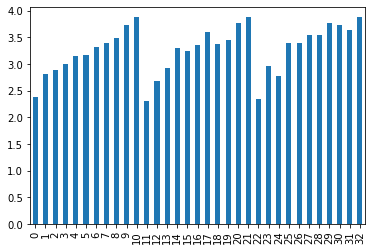

In [8]:
topology_data['shortest_path'].plot(kind='bar')

## Visualize network

In [1]:
def read_df_as_network(filename):
    with open(filename, 'rt') as f:
        network_df = pd.read_csv(f, sep=' ', header = None)
        network = nx.from_pandas_edgelist(network_df, create_using=nx.DiGraph(), source = 0, target = 1)
        return network
    
network_test = read_df_as_network(os.path.join(ART_NET_PATH, "test.tsv"))

NameError: name 'os' is not defined

In [10]:
print(len(network_test.nodes))

300


### Network

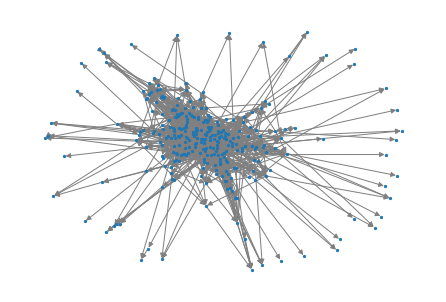

In [11]:
nx.draw(network_test, node_size = 5, edge_color = 'gray')

In [55]:
# def list_to_dictionary(your_list):
    
#     from collections import defaultdict
    
#     d = defaultdict(list)

#     for key, value in your_list:
#         d[key].append(value)
        
#     return d

# def get_degree_values(network):
    
#     in_degree_list = list_to_dictionary(list(network_test.in_degree()))
#     out_degree_list = list_to_dictionary(list(network_test.out_degree()))

#     return in_degree_list.keys(), np.concatenate(list(in_degree_list.values())),\
#     np.concatenate(list(out_degree_list.values()))

# nodes, in_degree, out_degree = get_degree_values(network_test)
# print(list(nodes))
# print(in_degree/sum(in_degree))
# print(out_degree/sum(out_degree))

# in_probs = pd.Series(nodes, in_degree/sum(in_degree))
# out_probs = pd.Series(nodes, out_degree/sum(out_degree))

### Minimum spanning tree

In [13]:
tree = nx.minimum_spanning_tree(network_test)
nx.draw(tree, node_size = 5, edge_color = 'gray')

NetworkXNotImplemented: not implemented for directed type

In [14]:
nx.diameter(network_test)

NetworkXError: Found infinite path length because the digraph is not strongly connected

In [65]:
nx.average_shortest_path_length(network_test)

AttributeError: 'list' object has no attribute 'is_directed'

In [63]:
degrees = [network_test.degree(n) for n in network_test.nodes()]
print(statistics.mean(degrees))

AttributeError: 'list' object has no attribute 'nodes'

In [64]:
plt.figure(figsize=(15, 10), dpi=80)
network_test = [d for n, d in network_test.degree]
plt.hist(network_test, bins=100, alpha=0.75)

AttributeError: 'list' object has no attribute 'degree'

<Figure size 1200x800 with 0 Axes>